<a href="https://colab.research.google.com/github/JCalandre/BunproSimulatorReview/blob/main/Bunpro_Simulation_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic variables used

You can edit this sell then run the codes pressing the Play button at the left of each code cell.

In [ ]:
#@title Installation (don’t run)
#!pip install autocalc

In [ ]:
#@title Initialisation and variables
import numpy as np
from autocalc.autocalc import Var
import ipywidgets as widgets

################################################################################
###################################VARIABLES####################################
################################################################################

#srs_timer = [4/24, 8/24, 1, 2, 4, 8, 14, 30, 61, 122, 183] # In Days
srs_timer = [1, 1, 1, 2, 4, 8, 14, 30, 61, 122, 183] # In Days
srs_timer.append(np.inf) # Last timer : Infinity

srs_timer_ghosts = [1,1,1,2,4]

# User modif OK
accuracy = Var('Accuracy', 
               initial_value = 0.85, 
               widget = widgets.FloatText()) # Your global accuracy

number_grammar_points = Var('Amount to learn', 
                            initial_value = 630, 
                            widget = widgets.FloatText(), 
                            description="Total number of grammar points th")

num_days_max = Var('Simulation days', 
                   initial_value = 365, 
                   widget = widgets.FloatText(),
                   description="Number of days we want to run for the simulation")
 
min_new_grammar_per_day = Var('Min grammar/day', 
                              initial_value = 0.5, 
                              widget = widgets.FloatText(),
                              description="Min amount of new grammar points we want to learn per day")

max_new_grammar_per_day = Var('Max grammar/day', 
                              initial_value = 3, 
                              widget = widgets.FloatText(),
                              description="Max amount of new grammar points we want to learn per day")

new_grammar_points_between_each_simu = Var('Padding', 
                                           initial_value = 1, 
                                           widget = widgets.FloatText(),
                                           description="Padding between each simulation")


Functions

In [ ]:
#@title Default title text
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets

from autocalc.autocalc import Var

def show_menu(history):
  display(accuracy)
  display(number_grammar_points)
  display(num_days_max)
  display(min_new_grammar_per_day)
  display(max_new_grammar_per_day)
  display(new_grammar_points_between_each_simu)
  fig = plt.figure()
  fig.set_size_inches(30, 10)
  ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
  plt.xlabel("Days")
  plt.ylabel("Reviews per day")
  plt.grid()
    

  plt.title(f"Simulation of number of reviews per day if Accuracy = {accuracy.get()}")
    
  for idx, npd in enumerate(history):
    ax.plot(history[npd], label = f"{round(npd,2)} new Grammar per day")
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


  plt.show()
  

def func_history(number_grammar_points,
                 min_new_grammar_per_day, 
                 max_new_grammar_per_day, 
                 new_grammar_points_between_each_simu,
                 num_days_max,
                 accuracy):

  list_simu = np.arange(min_new_grammar_per_day,
                      max_new_grammar_per_day+new_grammar_points_between_each_simu,
                      new_grammar_points_between_each_simu)
  history = {} #np.array([[0 for col in range(int(num_days_max))] for row in list_simu])
  history_ghosts = {}
  for new_grammar_point_per_day in tqdm(list_simu): # Loop for each number of new grammar points
    current_history = []
    current_history_ghosts = []
    srs_levels = {i:{} for i in range(12,-1, -1)}
    srs_levels_ghosts = {i:{} for i in range(5,-1, -1)}
    
    # Create array of new grammar points
    remaining_grammar = number_grammar_points
    i=0
    while remaining_grammar > 0:
      srs_levels[0][i] = min(new_grammar_point_per_day, remaining_grammar)
      remaining_grammar-=new_grammar_point_per_day
      i+=1

    for i in range(int(num_days_max)):
      reviews_today = 0
      for key,_ in srs_levels.items():
        if key == 12:
          continue


        # Update non_ghosts
        try:
          # Calculate how many are correct today
          reviews_today = reviews_today+srs_levels[key][i]
          new_val = srs_levels[key][i]*accuracy
          failed_val = srs_levels[key][i]-new_val
          
          # Update correct ones
          try:
            # Already something at this date
            srs_levels[key+1][i+srs_timer[key]] = srs_levels[key+1][i+srs_timer[key]]+new_val
          except:
            # 1st review at this date
            srs_levels[key+1][i+srs_timer[key]] = new_val
          
          # Report the fail ones
          try:
            srs_levels[key][i+srs_timer[key]] = srs_levels[key][i+srs_timer[key]]+failed_val
          except:
            srs_levels[key][i+srs_timer[key]] = failed_val
          
          # Add the ghost
          try:
            srs_levels_ghosts[0][i] = srs_levels_ghosts[0][i]+failed_val
          except:
            srs_levels_ghosts[0][i] = failed_val
          
          srs_levels[key].pop(i)
          
        except:
          pass
      current_history.append(reviews_today)
      history[new_grammar_point_per_day] = current_history

      reviews_today_ghosts = 0
      for key,_ in srs_levels_ghosts.items():
        if key == 5:
          continue 
        # Update ghosts
        try:
          # Calculate how many are correct today
          reviews_today_ghosts = reviews_today_ghosts+srs_levels_ghosts[key][i]
          new_val = srs_levels_ghosts[key][i]*accuracy
          failed_val = srs_levels_ghosts[key][i]-new_val

          # Update correct ones
          try:
            # Already something at this date
            srs_levels_ghosts[key+1][i+srs_timer_ghosts[key]] = srs_levels_ghosts[key+1][i+srs_timer_ghosts[key]]+new_val
          except:
            # 1st review at this date
            srs_levels_ghosts[key+1][i+srs_timer_ghosts[key]] = new_val
          
          # Report the fail ones
          try:
            srs_levels_ghosts[key][i+srs_timer_ghosts[key]] = srs_levels_ghosts[key][i+srs_timer_ghosts[key]]+failed_val
          except:
            srs_levels_ghosts[key][i+srs_timer_ghosts[key]] = failed_val
            
          srs_levels_ghosts[key].pop(i)
          
        except:
          pass
      current_history_ghosts.append(reviews_today_ghosts)
    history_ghosts[new_grammar_point_per_day] = current_history_ghosts
  
  clear_output()
  show_menu(history)

  return history


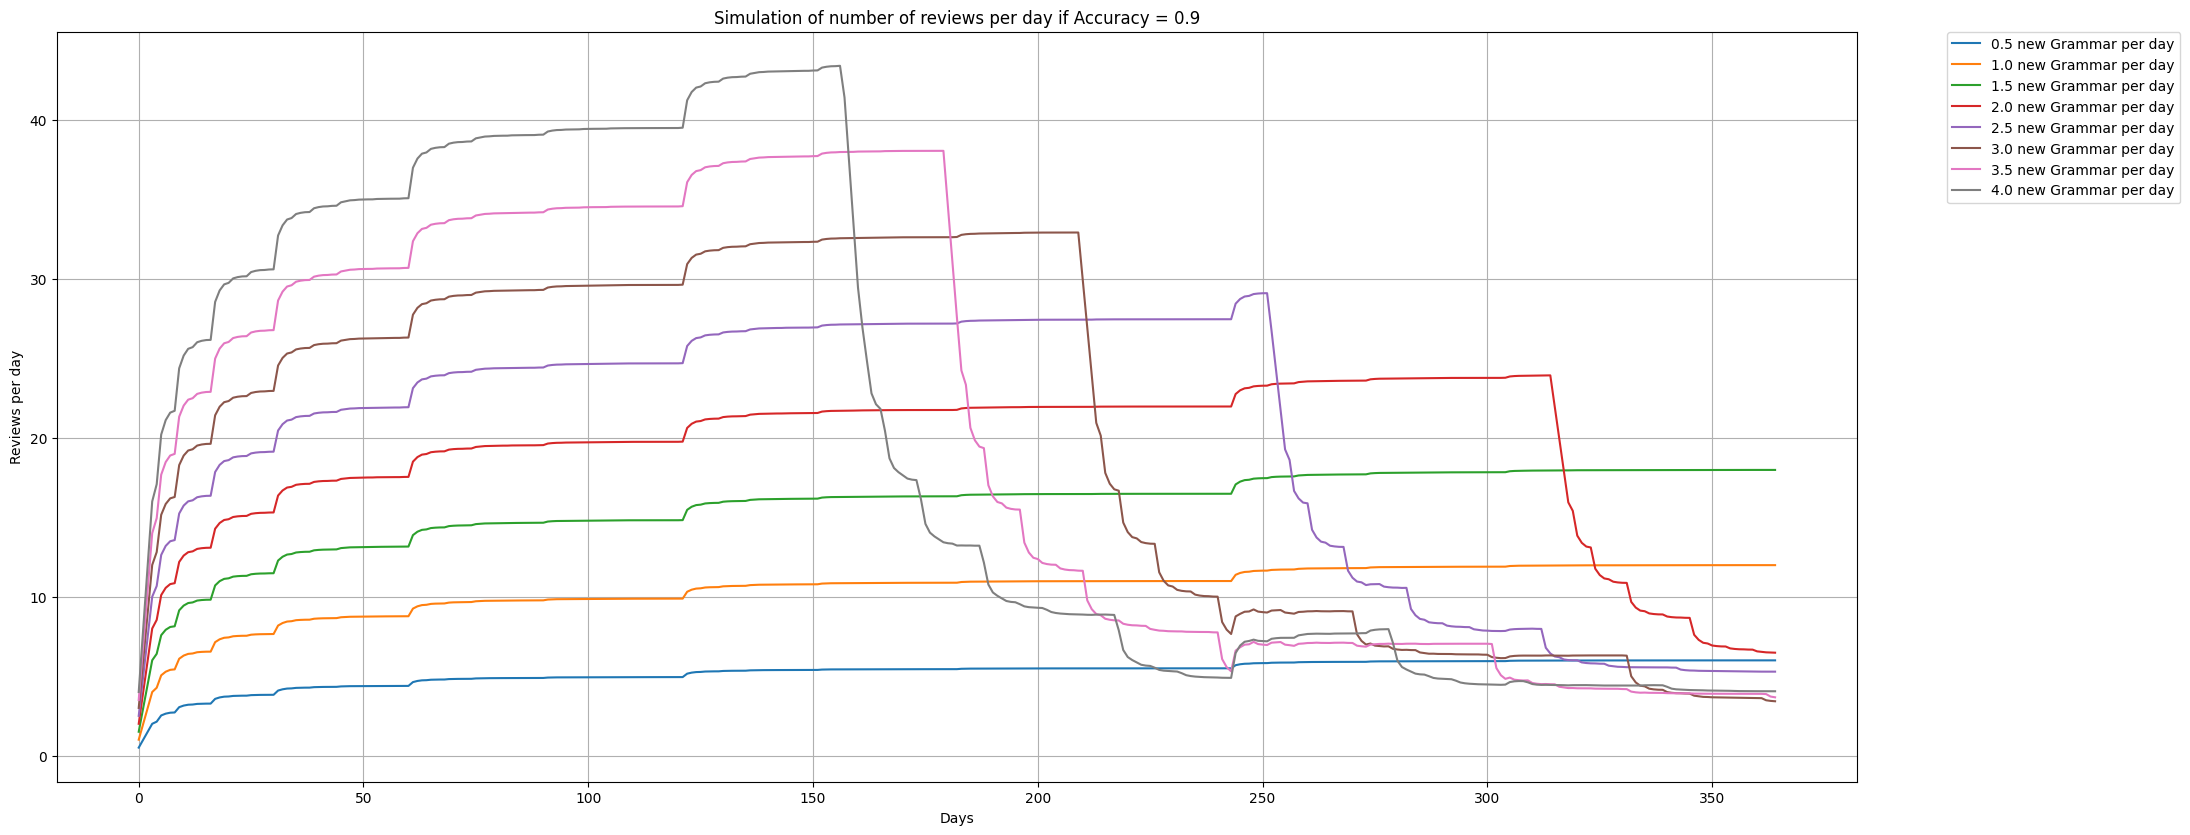

In [ ]:
#@title Default title text
from autocalc.autocalc import Var


################################################################################
######################################MAIN######################################
################################################################################


history = Var('history', fun=func_history, 
              inputs=[number_grammar_points,
                      min_new_grammar_per_day, 
                      max_new_grammar_per_day, 
                      new_grammar_points_between_each_simu,
                      num_days_max,
                      accuracy
                      ])